# **Size project**: Bulk RNA-Seq analysis
Gastruloids have different initial cell numbers and are collected at different timepoints.

**48h:**
- 20 cells
- 300 cells

**72h:** 
- 20 cells
- 300 cells

**120h:**
- 20 cells
- 75 cells
- 150 cells
- 300 cells

In [10]:
# load packages
import pandas as pd
import os
import glob

import seaborn as sns
import matplotlib.pyplot as plt
import textwrap
import matplotlib as mpl
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'

from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
import pydeseq2 as deseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.preprocessing import deseq2_norm

import gseapy as gp

import warnings
warnings.filterwarnings("ignore")

from custom_functions import *

save_format = "tiff"

In [11]:
# paths
data='data'

# output folders
results='results'

subfolders=['preprocessing','figures','de']

for s in subfolders:
    os.makedirs(f'{results}/{s}', exist_ok=True)

# 0. Load counts and metadata

In [12]:
analysis_name='sizeproject'

In [13]:
#Counts
counts = pd.read_csv(f'{data}/{analysis_name}_counts.csv',index_col=0).T
counts = counts.loc[:,~counts.columns.duplicated()].copy() #Remove potentially duplicated genes names (very few and irrelevant genes are duplicated)
counts.head()

Gene,Gm18956,Gm37180,Gm37363,Gm37686,Gm1992,Gm37329,Gm7341,Gm38148,Gm19938,Gm10568,...,Gm16367,AC163611.1,AC163611.2,AC140365.1,AC124606.2,AC124606.1,AC133095.2,AC133095.1,AC234645.1,AC149090.1
48h_20c_1,0,8,23,0,0,1,0,6,19,0,...,0,0,0,0,0,0,0,0,0,1195
48h_20c_2,0,3,19,9,0,1,2,0,18,1,...,0,0,0,0,0,0,0,0,0,1202
48h_20c_3,0,5,6,3,0,0,0,7,6,0,...,0,0,0,2,0,0,3,0,0,1302
48h_300c_1,0,8,17,5,0,0,3,1,16,0,...,0,0,0,0,0,0,1,0,0,1395
48h_300c_2,1,5,28,6,0,1,1,9,41,0,...,0,0,0,0,0,0,2,0,0,1546


In [14]:
#Metadata
meta = pd.read_csv(f"{data}/metadata_{analysis_name}.csv",index_col=0)
meta.head()

,Condition
48h_20c_1,48h_20c
48h_20c_2,48h_20c
48h_20c_3,48h_20c
48h_300c_1,48h_300c
48h_300c_2,48h_300c


# Preprocessing and QC

In [15]:
print(f"Samples in dataset: {counts.shape[0]}")
print(f"Genes in dataset: {counts.shape[1]}")
print(f"Total reads: {counts.sum(axis=1).sum()}")

Samples in dataset: 24
Genes in dataset: 55364
Total reads: 882430436


In [16]:
# # Removing genes that are not expressed in any sample
# counts=counts.loc[:,counts.sum()>0]

# print(f'Genes kept: {counts.shape[1]}')

**COUNTS SUMMARY**

In [17]:
counts.T.describe().to_csv(f"{results}/preprocessing/counts_summary.csv")

**LIBRARY SIZES**

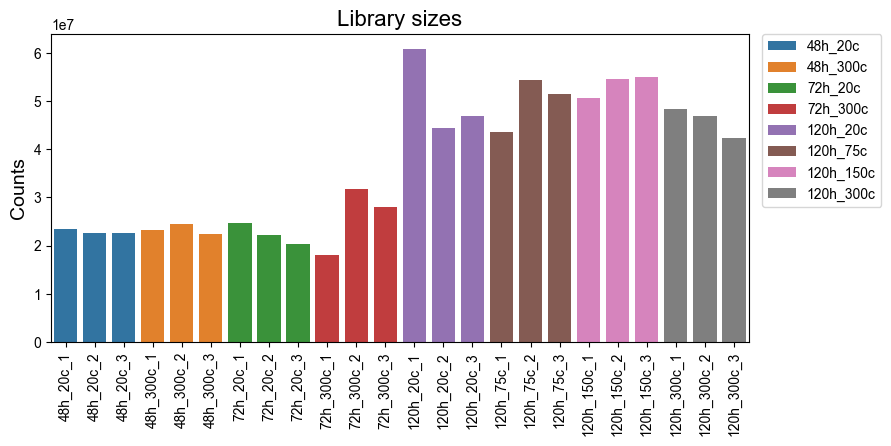

In [18]:
fig,ax=plt.subplots(1,1,figsize=(9,4))
sns.barplot(counts, x=counts.index, y=counts.sum(axis=1),ax=ax, hue=meta.Condition.values)

plt.xticks(rotation=90)
plt.title('Library sizes', size=16)
plt.ylabel('Counts', size=14)
plt.xlabel('')

# create result folder
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)
plt.savefig(f"results/preprocessing/library_sizes.{save_format}", dpi=300)
plt.show()

**GENE DISTRIBUTION**

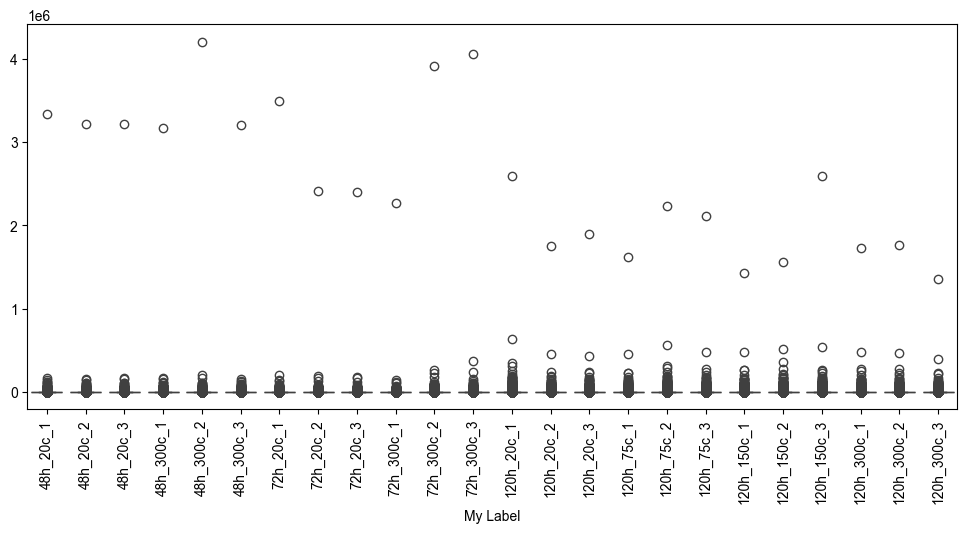

<Figure size 640x480 with 0 Axes>

In [19]:
fig,ax=plt.subplots(1,1,figsize=(12,5))

sns.boxplot(data=counts.T)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontname='Arial')
plt.xlabel('My Label', family='Arial')
plt.show()
plt.savefig(f"results/preprocessing/gene_distribution.{save_format}")

One **outlier** with abnormal gene counts gene seems to be present in every samples.

In [20]:
print(counts.T.sum(axis=1).sort_values(ascending=False)[:10])
sorted_counts=counts.T.sum(axis=1).sort_values(ascending=False)[:100] #top100 genes by counts

Gene
CT010467.1    61549833
Eef1a1         8063172
Hsp90ab1       4520591
mt-Co1         3878932
Eef2           2900594
mt-Rnr2        2725843
Tubb5          2648527
Npm1           2605866
mt-Cytb        2475979
mt-Nd1         2412345
dtype: int64


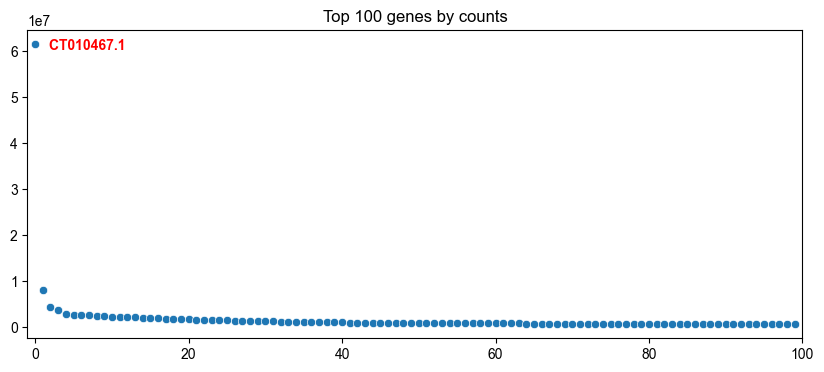

In [21]:
fig,ax=plt.subplots(1,1, figsize=(10,4))
sns.scatterplot( x=list(range(0, len(sorted_counts))), y=sorted_counts.values)
ax.set_xlim(-1,100)

ax.set_title('Top 100 genes by counts')

ax.text(0.08, 0.95, 'CT010467.1 ', horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes, color='red',fontweight='bold')
plt.savefig(f"results/preprocessing/top100_sorted_gene_distribution.{save_format}")

Therefore, for the downstream analysis CT010467.1 gene will be removed as it is clearly an outlier and can affect the following analysis.

(*From literature*) 

This abnormal high expression of these genes ( and others like Erf1 or Gm42418) might imply a rRNA contamination. Ribosomal sequences from 18s have very similar sequences to Chr17 in mouse, where these genes overlap.

In [22]:
# removing outlier
counts=counts.drop('CT010467.1', axis=1)

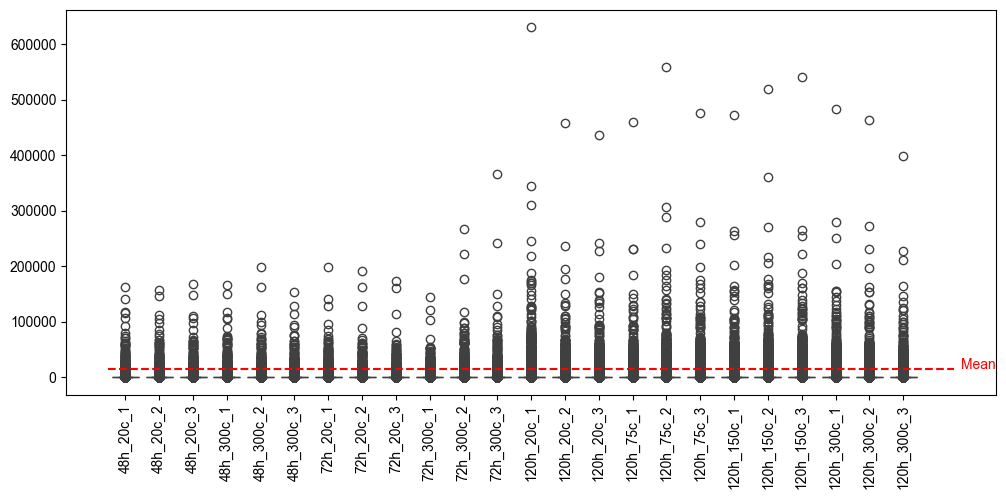

In [23]:
fig,ax=plt.subplots(1,1,figsize=(12,5))

sns.boxplot(data=counts.T)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.hlines(y=counts.T.sum(axis=1).mean(), xmin=-0.5, xmax=24.5, linestyles='--', color='red')
ax.text(x=24.7, y=counts.T.sum(axis=1).mean(), s='Mean', color='red')
plt.savefig(f"results/preprocessing/gene_distribution_corrected.{save_format}")
plt.show()

Although, some genes have multiple time the mean expression, especially in the 120h batch, but they are not going to me treated as outliers

**NORMALIZED COUNTS**

Size factor normalization by median of ratios (DESeq2). Big outliers can 

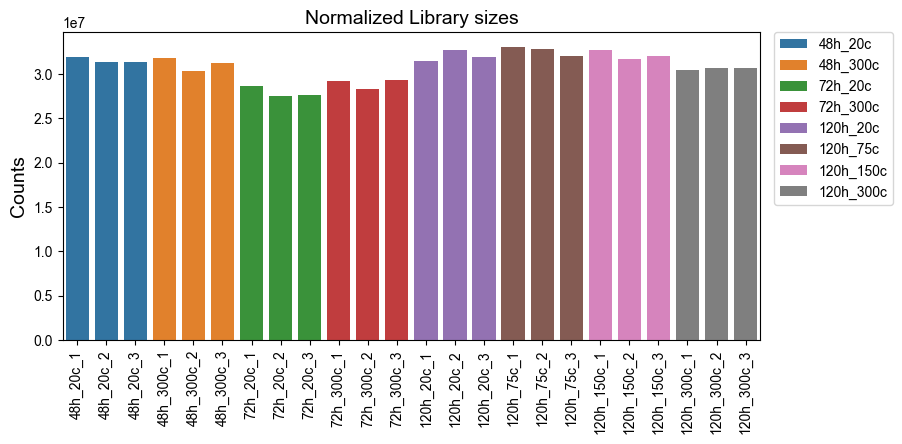

In [24]:
# run deseq2_norm function
norm_counts=deseq2_norm(counts)[0]

fig,ax=plt.subplots(1,1,figsize=(9,4))
sns.barplot(norm_counts, x=norm_counts.index, y=norm_counts.sum(axis=1),ax=ax, hue=meta['Condition'].values)

plt.xticks(rotation=90)
plt.title('Normalized Library sizes', size=14)
plt.ylabel('Counts', size=14)
plt.xlabel('')

# create result folder
plt.savefig(f"results/preprocessing/normalized_library_sizes.{save_format}")
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

# save normalized counts table
norm_counts.T.to_csv(f"data/normalized_counts.csv")

# 1. Analysis


Counts need to be trasnformed due to the nature of sequencing experiments: normalization of non-homoskedastic data (skewed distribution). 

Normally, VST improves log1p performance, which overweights low count genes.

In [25]:
# dds object is constructed for the selected condition (if None, all samples included)
# vst trasnformation is computed
condition='whole'
dds, vst= dds_vst_function(data=counts, metadata=meta)

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 3.99 seconds.

Fitting dispersion trend curve...
... done in 7.10 seconds.



#### Feature selection

We use a simple variance threshold to choose the most varying genes.

Free parameters: **threshold**

In [26]:
# feature selection
fs = VarianceThreshold(threshold=4)
vst_fs=fs.fit_transform(vst)

print("Genes Retained: ",vst_fs.shape[1])

Genes Retained:  1035


PCA

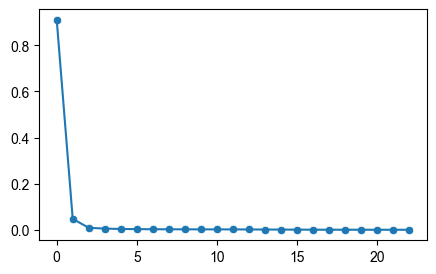

In [27]:
# pca
pca=PCA(n_components=vst_fs.shape[0]-1, svd_solver='auto')
pcs=pca.fit_transform(vst_fs)

# plotting
fig,ax= plt.subplots(1,1, figsize=(5,3))
# variance ratio, ax0
sns.lineplot(x=np.arange(0,pca.n_components),y=pca.explained_variance_ratio_, ax=ax)
sns.scatterplot(x=np.arange(0,pca.n_components),y=pca.explained_variance_ratio_, ax=ax)

plt.savefig(f'{results}/figures/explained_variance_pca_{condition}.{save_format}')

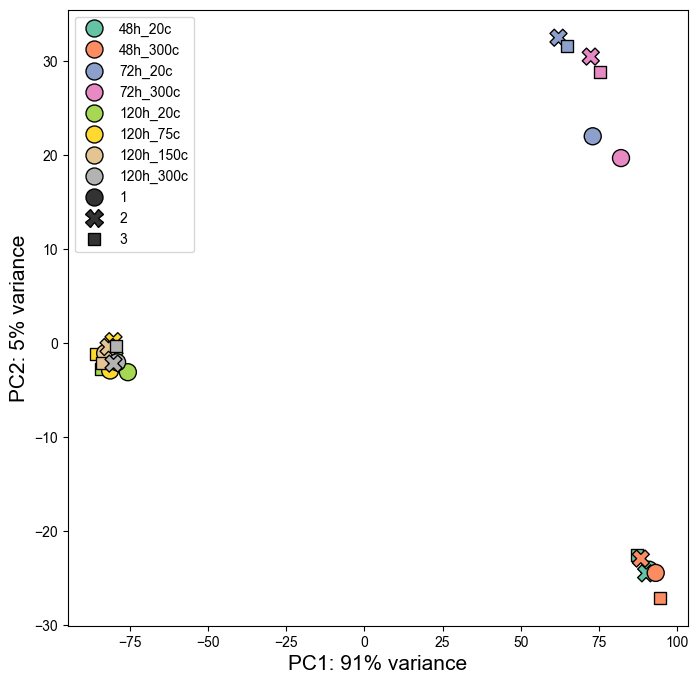

In [28]:
# pca plot, ax1
fig,ax=plt.subplots(1,1,figsize=(8,8))
sns.scatterplot(x=pcs[:,0], y=pcs[:,1], s=150, edgecolor='black',hue=[c[:-2] for c in vst.index], palette='Set2', style=[b[-1] for b in vst.index])
ax.set_xlabel(f'PC1: {int(np.round(pca.explained_variance_ratio_[0]*100,decimals=0))}% variance', fontsize=15)
ax.set_ylabel(f'PC2: {int(np.round(pca.explained_variance_ratio_[1]*100,decimals=0))}% variance', fontsize=15)

# save plot
plt.savefig(f"{results}/figures/pca_scatterplot_{condition}.{save_format}",bbox_inches="tight",transparent=True)

Dimensionality reduction by PCA clusters samples by timepoint clearly, but it seems difficult to distinguish intra-timepoint or batch effects differences as time has a huge weight in the analysis. 
For this reason, each timepoint is goig to be re-analyzed per separate.

# 48h

In [29]:
# dds object is constructed for the selected condition (if None, all samples included)
# vst trasnformation is computed
condition='48h'
dds, vst= dds_vst_function(data=counts, metadata=meta, condition=condition)

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 2.73 seconds.

Fitting dispersion trend curve...
... done in 5.16 seconds.



Benchmarking count transformation: **VST vs log1p**

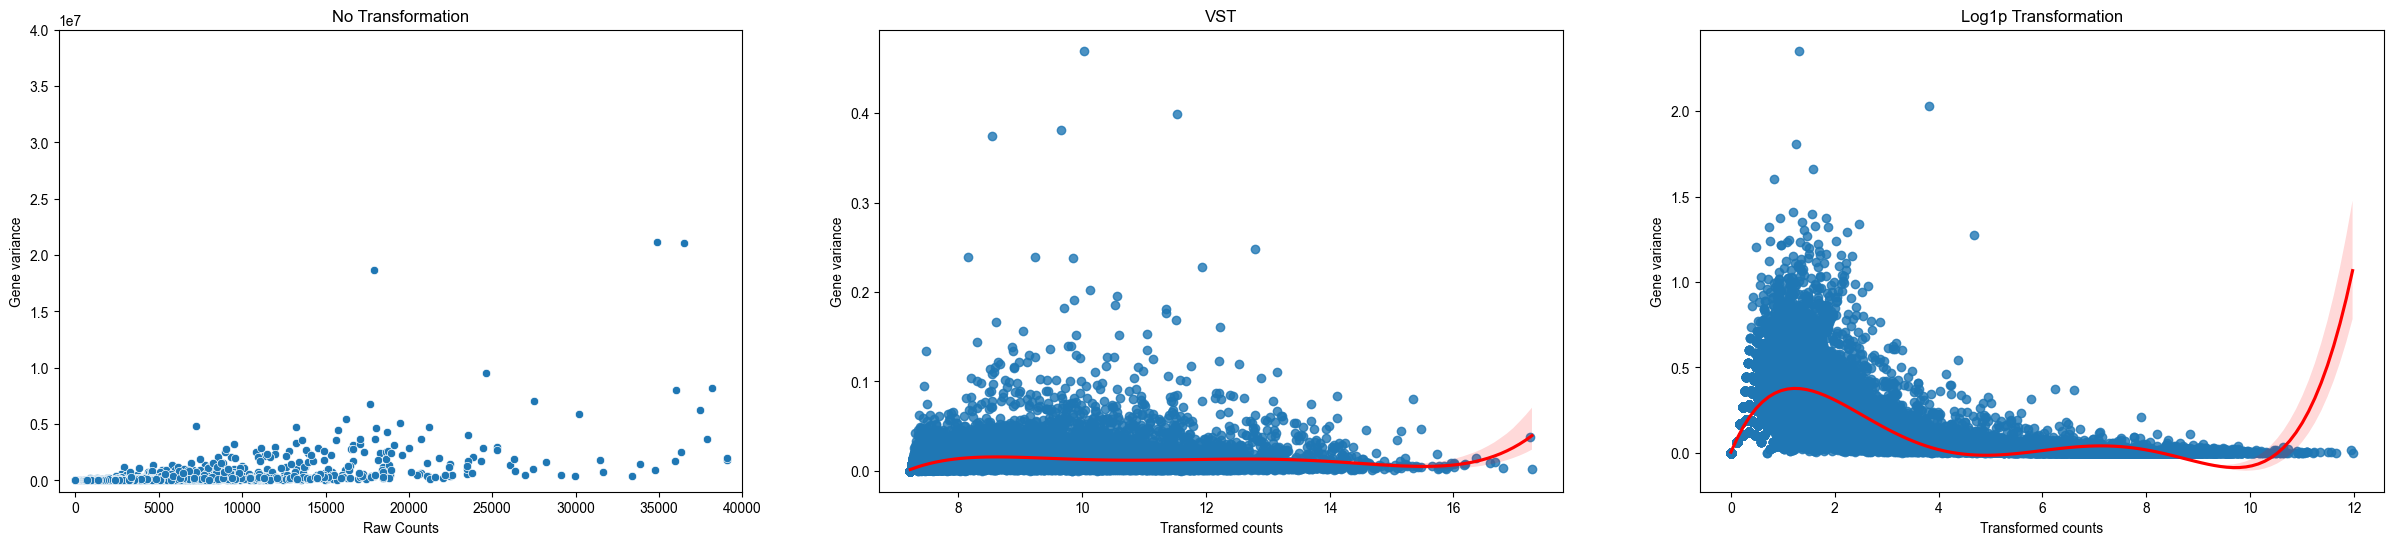

In [30]:
plot_transformations(data=dds.X,vst=vst, condition='48h')

Feature Selection

In [31]:
# feature selection
fs = VarianceThreshold(threshold=0.03)
vst_fs=fs.fit_transform(vst)

print("Genes Retained: ",vst_fs.shape[1])

Genes Retained:  697


PCA

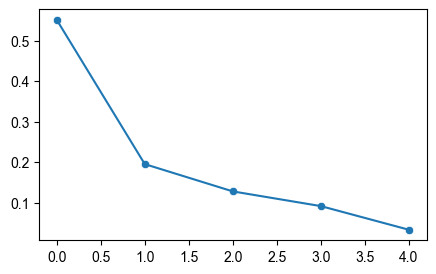

In [32]:
# pca
pca=PCA(n_components=vst_fs.shape[0]-1, svd_solver='auto')
pcs=pca.fit_transform(vst_fs)

# plotting
fig,ax= plt.subplots(1,1, figsize=(5,3))
# variance ratio, ax0
sns.lineplot(x=np.arange(0,pca.n_components),y=pca.explained_variance_ratio_, ax=ax)
sns.scatterplot(x=np.arange(0,pca.n_components),y=pca.explained_variance_ratio_, ax=ax)

plt.savefig(f'{results}/figures/explained_variance_pca_{condition}.{save_format}')

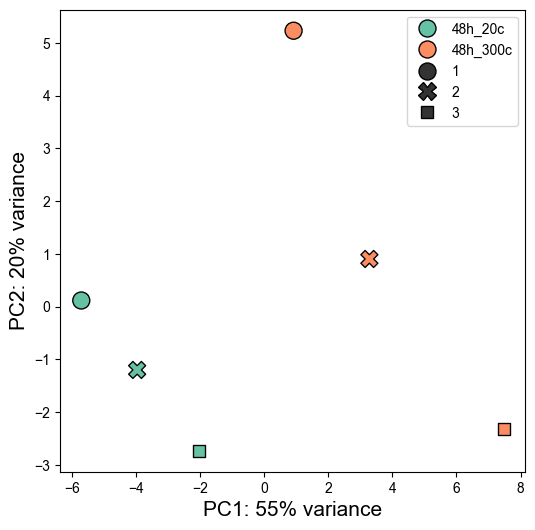

In [33]:
# pca plot
fig,ax=plt.subplots(1,1,figsize=(6,6))
sns.scatterplot(x=pcs[:,0], y=pcs[:,1], s=150, edgecolor='black',hue=[c[:-2] for c in vst.index], palette='Set2', style=[b[-1] for b in vst.index])
ax.set_xlabel(f'PC1: {int(np.round(pca.explained_variance_ratio_[0]*100,decimals=0))}% variance', fontsize=15)
ax.set_ylabel(f'PC2: {int(np.round(pca.explained_variance_ratio_[1]*100,decimals=0))}% variance', fontsize=15)

# save plot
plt.savefig(f"{results}/figures/pca_scatterplot_{condition}.{save_format}",bbox_inches="tight",transparent=True)


# 72h

VST

In [34]:
# dds object is constructed for the selected condition (if None, all samples included)
# vst trasnformation is computed
condition='72h'
dds, vst= dds_vst_function(data=counts, metadata=meta, condition=condition)

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 2.76 seconds.

Fitting dispersion trend curve...
... done in 5.34 seconds.



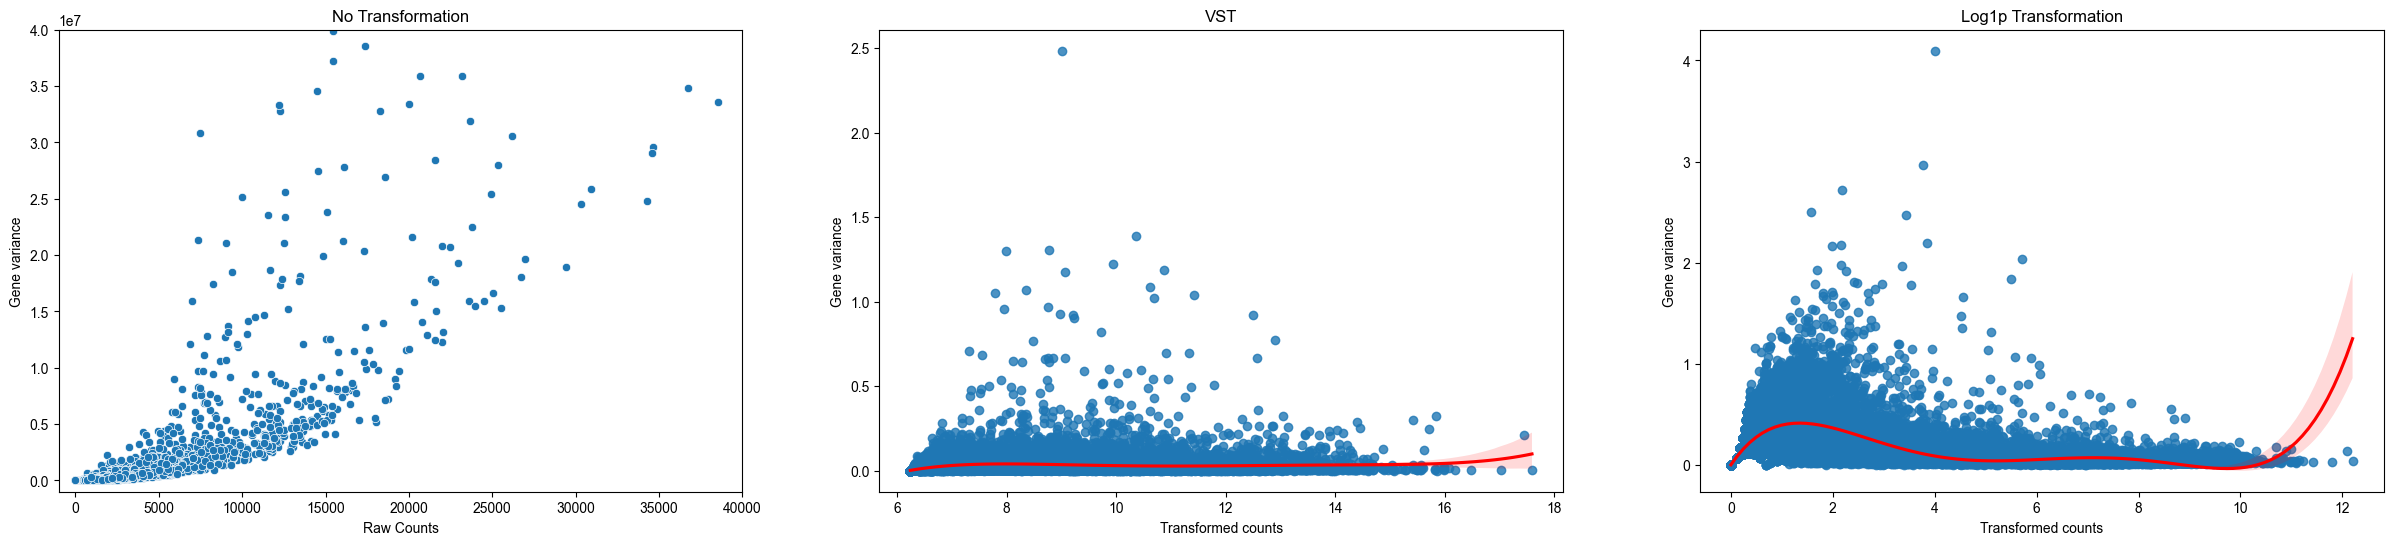

In [35]:
plot_transformations(data=dds.X,vst=vst, condition='72h')

Feature selection

In [36]:
# feature selection
fs = VarianceThreshold(threshold=0.07)
vst_fs=fs.fit_transform(vst)

print("Genes Retained: ",vst_fs.shape[1])

Genes Retained:  1012


PCA

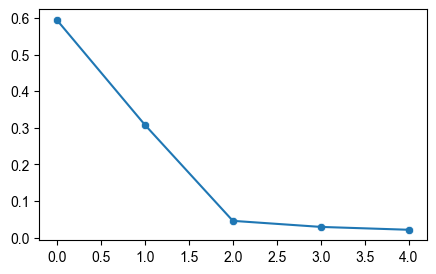

In [37]:
# pca
pca=PCA(n_components=vst_fs.shape[0]-1, svd_solver='auto')
pcs=pca.fit_transform(vst_fs)

# plotting
fig,ax= plt.subplots(1,1, figsize=(5,3))
# variance ratio, ax0
sns.lineplot(x=np.arange(0,pca.n_components),y=pca.explained_variance_ratio_, ax=ax)
sns.scatterplot(x=np.arange(0,pca.n_components),y=pca.explained_variance_ratio_, ax=ax)

plt.savefig(f'{results}/figures/explained_variance_pca_{condition}.{save_format}')

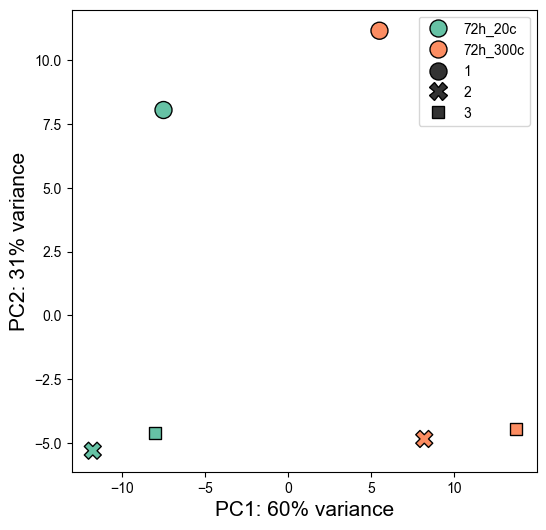

In [38]:
# pca plot, ax1
fig,ax=plt.subplots(1,1,figsize=(6,6))
sns.scatterplot(x=pcs[:,0], y=pcs[:,1], s=150, edgecolor='black',hue=[c[:-2] for c in vst.index], palette='Set2', style=[b[-1] for b in vst.index])
ax.set_xlabel(f'PC1: {int(np.round(pca.explained_variance_ratio_[0]*100,decimals=0))}% variance', fontsize=15)
ax.set_ylabel(f'PC2: {int(np.round(pca.explained_variance_ratio_[1]*100,decimals=0))}% variance', fontsize=15)

# save plot
plt.savefig(f"{results}/figures/pca_scatterplot_{condition}.{save_format}",bbox_inches="tight",transparent=True)


# 120h

In [39]:
# dds object is constructed for the selected condition (if None, all samples included)
# vst trasnformation is computed
condition='120h'
dds, vst= dds_vst_function(data=counts, metadata=meta, condition=condition)

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 3.88 seconds.

Fitting dispersion trend curve...
... done in 6.46 seconds.



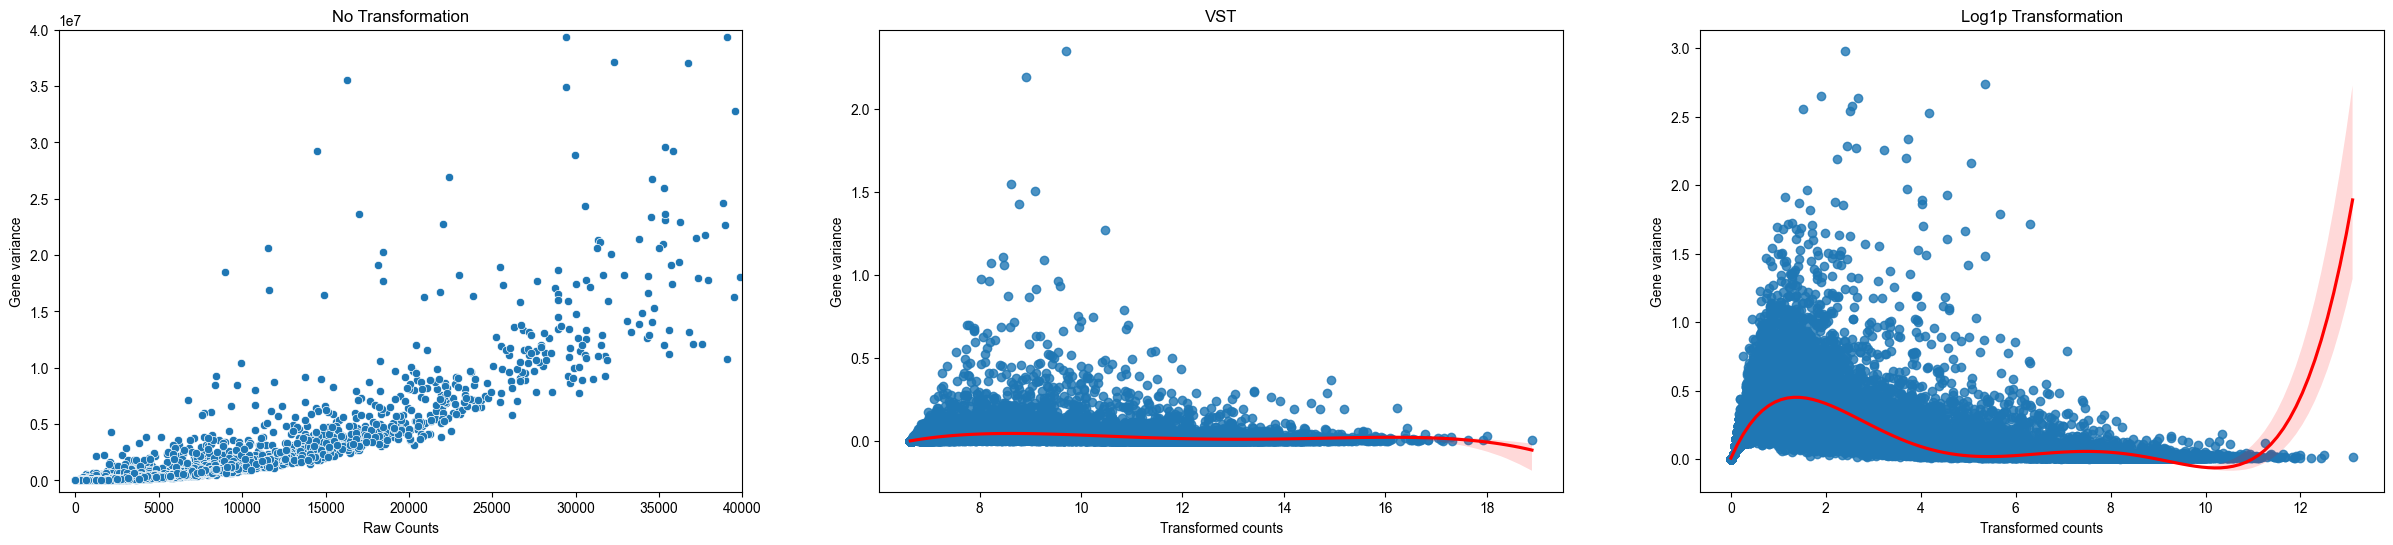

In [40]:
plot_transformations(data=dds.X,vst=vst, condition='120h')

In [41]:
# feature selection
fs = VarianceThreshold(threshold=0.07)
vst_fs=fs.fit_transform(vst)

print("Genes Retained: ",vst_fs.shape[1])

Genes Retained:  1167


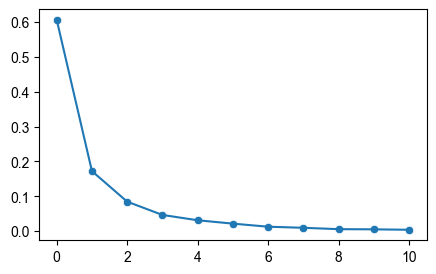

In [42]:
# pca
pca=PCA(n_components=vst_fs.shape[0]-1, svd_solver='auto')
pcs=pca.fit_transform(vst_fs)

# plotting
fig,ax= plt.subplots(1,1, figsize=(5,3))
# variance ratio, ax0
sns.lineplot(x=np.arange(0,pca.n_components),y=pca.explained_variance_ratio_, ax=ax)
sns.scatterplot(x=np.arange(0,pca.n_components),y=pca.explained_variance_ratio_, ax=ax)

plt.savefig(f'{results}/figures/explained_variance_pca_{condition}.{save_format}')

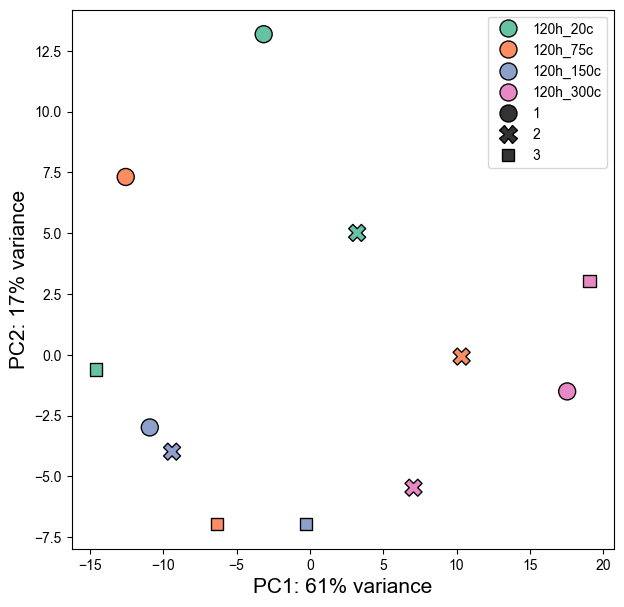

In [43]:
# pca plot, ax1
fig,ax=plt.subplots(1,1,figsize=(7,7))
sns.scatterplot(x=pcs[:,0], y=pcs[:,1], s=150, edgecolor='black',hue=[c[:-2] for c in vst.index], palette='Set2', style=[b[-1] for b in vst.index])
ax.set_xlabel(f'PC1: {int(np.round(pca.explained_variance_ratio_[0]*100,decimals=0))}% variance', fontsize=15)
ax.set_ylabel(f'PC2: {int(np.round(pca.explained_variance_ratio_[1]*100,decimals=0))}% variance', fontsize=15)

# save plot
plt.savefig(f"{results}/figures/pca_scatterplot_{condition}.{save_format}",bbox_inches="tight",transparent=True)


Across all timepoints replicates seem to suffer from a big variability.

Maybe it is due to batch effects, manipulation errors or the object of study by themselves (gastruloid heterogeneity/stochasticty).


## Marker gene exression at 120h

Studying sets of marker genes between across samples

In [44]:
# read markers
markers= pd.read_excel('markers.xlsx',header=None, sheet_name=None)

Re-run dds and vst without 120h_300c_1

In [107]:
dds, vst = dds_vst_function(data=counts, metadata=meta, condition='120h')

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 3.41 seconds.

Fitting dispersion trend curve...
... done in 6.56 seconds.



### Clustermap

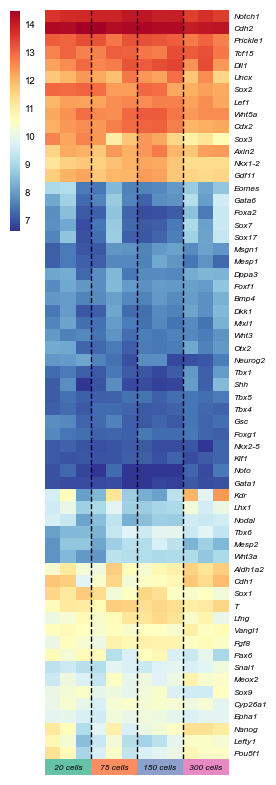

In [133]:
# plotting

# Defining palette for colorbar
p=sns.color_palette("Set2")[:4]
barcolors=[p[0]]*3+[p[1]]*3+[p[2]]*3+[p[3]]*3

cg= sns.clustermap(vst.T.loc[markers['markers'].iloc[:,0].values], metric='euclidean',
               col_cluster=False,row_cluster=True, cmap='RdYlBu_r',
                yticklabels=True, xticklabels=True,  cbar_pos=(0.08, 0.58, 0.03, 0.2), linecolor='white',
                figsize=(6.5/2,11), col_colors=barcolors)
cg.tick_params(axis=u'both', which=u'both',length=0)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)

# labels
labels=['20 cells', '75 cells', '150 cells', '300 cells']
cg.ax_heatmap.set_xticks([1.5, 4.5, 7.5, 10.5], labels=labels, rotation=0, fontstyle='italic', fontsize=6)
cg.ax_heatmap.set_yticklabels(cg.ax_heatmap.get_yticklabels(), rotation=0, fontstyle='italic', fontsize=6)
lut = dict(zip(labels, sns.hls_palette(len(labels))), l=0.5, s=0.8)
row_colors = pd.DataFrame(labels)[0].map(lut)

for i in range(1, len(labels)):
    cg.ax_heatmap.axvline(x=(i*3), color='black', linestyle='--', linewidth=1)

# # color bar position manually
box = cg.ax_col_colors.get_position()
box_heatmap = cg.ax_heatmap.get_position()
cg.ax_col_colors.set_position([box_heatmap.min[0], 0.085, box.width, 0.03])

colorbar = cg.cax
colorbar.tick_params(labelsize=7) 

plt.margins(x=0,y=0)

plt.savefig(f'{results}/figures/markers_clustermap_120h.{save_format}',dpi=300,bbox_inches='tight')



## Correlating fate genes at 120h

Studying how close conditions are according to fate marker genes

In [47]:
fate=markers['fate'].iloc[:,0].tolist()

In [48]:
# subset fate markers
vst_fate=vst.loc[:,fate]

# mean expression per condition
df_mean=vst_fate.T
df_mean.columns=[x.split('_')[1] for x in df_mean.columns.values]

# mean conditions
df_mean=df_mean.groupby(level=0,axis=1).mean()
# reorder columns
df_mean = df_mean[['20c', '75c', '150c', '300c']]
df_mean.columns =['20 cells', '75 cells', '150 cells', '300 cells']

df_corr=df_mean.corr()

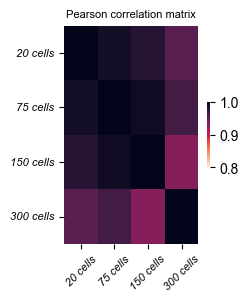

In [90]:
#### Correlation matrix
fig,ax=plt.subplots(1,1,figsize=(6.5/3,8.5/3))
sns.heatmap(df_corr, annot=False, cmap="rocket_r", ax=ax,cbar_kws={"shrink": 0.3}, vmin=0.8)
ax.set_xticklabels(ax.get_yticklabels(),rotation=45, fontstyle='italic', fontsize=8)
ax.set_yticklabels(ax.get_xticklabels(),rotation=0, fontstyle='italic', fontsize=8)
ax.set_title('Pearson correlation matrix',fontsize=8)
plt.savefig(f'{results}/figures/pearson_correlation_dev_markers.{save_format}', dpi=300,bbox_inches='tight')

# DE analysis 120h

Wald test to explore differentially expressed genes between conditions

**Thresholds**:
- LogfoldChange
- P-value

In [50]:
dds,vst=dds_vst_function(data=counts, metadata=meta, condition='120h')

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.15 seconds.

Fitting dispersion trend curve...
... done in 6.58 seconds.



In [51]:
# run deseq2 to compute variances, estimate LFC
dds.deseq2()

Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 4.00 seconds.

Fitting dispersion trend curve...
... done in 6.86 seconds.

Fitting MAP dispersions...
... done in 4.48 seconds.

Fitting LFCs...
... done in 2.93 seconds.

Refitting 16 outliers.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



In [52]:
### Pair-wise comparison
comparisons = [['120h-20c','120h-300c'],['120h-75c','120h-300c'],['120h-150c','120h-300c']]
stat_res_df_l=[]
degs_l=[]
for comparison in comparisons:
    stat_res_df, degs_df = pairwise_comparison(dds, comparison[0], comparison[1], lfc_threshold= 1, padj_threshold = 0.1, save_format='csv')
    stat_res_df_l.append(stat_res_df)
    degs_l.append(degs_df)


Log2 fold change & Wald test p-value: Condition 120h-20c vs 120h-300c


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene,,,,,,
Gm18956,0.000000,NaN,NaN,NaN,NaN,NaN
Gm37180,0.162338,-0.098462,4.531926,-0.021726,0.982666,NaN
Gm37363,0.134506,1.513260,4.654941,0.325087,0.745115,NaN
Gm37686,0.143109,0.863330,4.730107,0.182518,0.855176,NaN
Gm1992,0.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
AC124606.1,0.000000,NaN,NaN,NaN,NaN,NaN
AC133095.2,1.316887,-0.957132,3.035397,-0.315323,0.752516,NaN
AC133095.1,0.000000,NaN,NaN,NaN,NaN,NaN


Log2 fold change & Wald test p-value: Condition 120h-75c vs 120h-300c


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene,,,,,,
Gm18956,0.000000,NaN,NaN,NaN,NaN,NaN
Gm37180,0.162338,-1.024691,4.729437,-0.216662,0.828471,NaN
Gm37363,0.134506,-0.062899,4.919670,-0.012785,0.989799,NaN
Gm37686,0.143109,-0.062899,4.919668,-0.012785,0.989799,NaN
Gm1992,0.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
AC124606.1,0.000000,NaN,NaN,NaN,NaN,NaN
AC133095.2,1.316887,-3.475689,3.512675,-0.989471,0.322433,NaN
AC133095.1,0.000000,NaN,NaN,NaN,NaN,NaN


Log2 fold change & Wald test p-value: Condition 120h-150c vs 120h-300c


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene,,,,,,
Gm18956,0.000000,NaN,NaN,NaN,NaN,NaN
Gm37180,0.162338,-1.148054,4.728788,-0.242780,0.808176,NaN
Gm37363,0.134506,-0.186263,4.919042,-0.037866,0.969795,NaN
Gm37686,0.143109,0.775508,4.728820,0.163996,0.869734,NaN
Gm1992,0.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
AC124606.1,0.000000,NaN,NaN,NaN,NaN,NaN
AC133095.2,1.316887,0.039664,2.978168,0.013318,0.989374,NaN
AC133095.1,0.000000,NaN,NaN,NaN,NaN,NaN


## Number of DEGs per condition

In [53]:
comparison_lab=['20cells / 300cells','75cells / 300cells','150cells / 300cells']
dfs_l=[]

for j,i in enumerate(degs_l):
    i['comparison']=comparison_lab[j]

    i['+/-']=''
    i['+/-'][i.log2FoldChange>0]='up'
    i['+/-'][i.log2FoldChange<0]='down'

    i['n_degs']=''
    i['n_degs'][i['+/-']=='up']=i[i.log2FoldChange>0].shape[0]
    i['n_degs'][i['+/-']=='down']=i[i.log2FoldChange<0].shape[0]
    dfs_l.append(i)

dfs=pd.concat(dfs_l, axis=0)

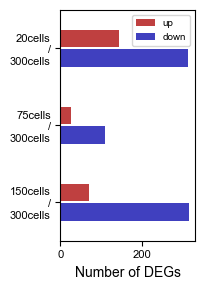

In [54]:
fig,ax=plt.subplots(1,1, figsize=(2.15,3))
b=sns.barplot(dfs, y='comparison',x='n_degs', hue='+/-', gap=0.1, orient='h', width=0.5, palette=['r','b'], saturation=0.5)
ax.set_xlabel('Number of DEGs')
ax.set_ylabel('')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
ax.set_yticklabels([textwrap.fill(e, 8) for e in comparison_lab], fontsize=8)
fig.tight_layout()
ax.legend(loc='upper right', fontsize=7)
plt.savefig(f'{results}/figures/degs_up_down_vs_300_120h.{save_format}', dpi=300,bbox_inches='tight')

## Differential fate expression: 
### 20cells vs 300cells at 120h

In [55]:
markers_lfc=['Tbx6','Msgn1','Mesp2','Ripply2','Dll1','Hes7','Lfng',
             'Otx2','Sox3','Pou3f1','Foxg1','En1',
             'Sox2','Sox1','Pax6','Olig2','Neurog2']

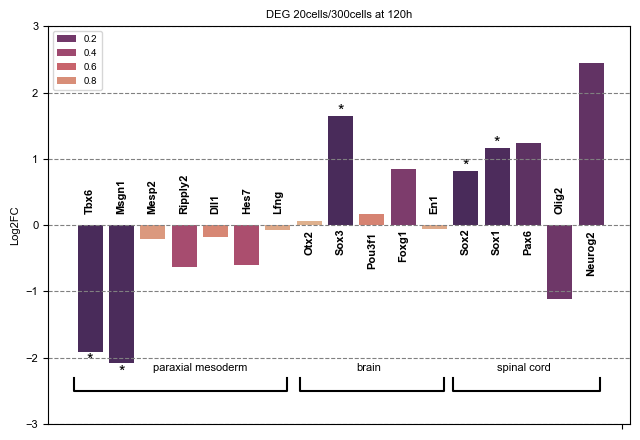

In [62]:
d_= stat_res_df_l[0].loc[markers_lfc,:]

fig,ax=plt.subplots(1,1, figsize=(6.5,4.5))
g=sns.barplot(x=range(len(markers_lfc)), y=d_.log2FoldChange.values, ax=ax, hue=d_['padj'], palette='flare_r')

ax.set_title('DEG 20cells/300cells at 120h', fontsize=8)
ax.set_ylim(-3,3)
ax.set_ylabel('Log2FC', fontsize=8)
ax.set_xticklabels('')
ax.set_xticks('')
ax.tick_params(axis='y', which='major', labelsize=8)
ax.legend(fontsize=7)

for index, row in enumerate(d_.index):
    if d_.loc[row,'log2FoldChange']< 0:
        g.text(index, 0.2, row, color='black', ha="center", rotation=90, fontsize=8, fontweight='bold')
    elif d_.loc[row,'log2FoldChange']>0:
        g.text(index, -len(row)*0.105, row, color='black', ha="center", rotation=90, fontsize=8, fontweight='bold')
        
for index, row in enumerate(d_.index):
    if d_.loc[row,'padj']< 0.1 and  d_.loc[row,'log2FoldChange']>0 :
        g.text(index, d_.loc[row,'log2FoldChange'], '*', color='black', ha="center", fontsize=12)
    if d_.loc[row,'padj']< 0.1 and  d_.loc[row,'log2FoldChange']<0:
        g.text(index, d_.loc[row,'log2FoldChange']*1.1, '*', color='black', ha="center", fontsize=12)

# annotation
g.plot([-0.5, -0.5, 6.3, 6.3], [-2.3, -2.5, -2.5, -2.3], lw=1.5, color='black')
g.text(2,-2.2,'paraxial mesoderm', fontsize=8)
g.plot([6.7, 6.7, 11.3,11.3], [-2.3, -2.5, -2.5, -2.3], lw=1.5, color='black')
g.text(8.5,-2.2,'brain', fontsize=8)    
g.plot([11.6, 11.6, 16.3, 16.3], [-2.3, -2.5, -2.5, -2.3], lw=1.5, color='black')
g.text(13,-2.2,'spinal cord', fontsize=8)

ax.yaxis.grid(color='gray', linestyle='dashed')
fig.tight_layout()
plt.savefig(f'{results}/figures/diff_exp_fate_20_vs_300_120h.{save_format}', dpi=300,bbox_inches='tight')

## Volcano plot

In [65]:
genes = ['Fgf8','Nodal','Wnt3','Wnt3a','Sox2','Tbx6']

In [66]:
dds, vst = dds_vst_function(data=counts, metadata=meta, condition='72h')
dds.deseq2()

Fitting size factors...
... done in 0.01 seconds.



Fitting dispersions...
... done in 2.72 seconds.

Fitting dispersion trend curve...
... done in 5.35 seconds.

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 2.73 seconds.

Fitting dispersion trend curve...
... done in 5.16 seconds.

Fitting MAP dispersions...
... done in 3.00 seconds.

Fitting LFCs...
... done in 2.18 seconds.

Refitting 0 outliers.



In [85]:
from importlib import reload
import custom_functions
reload(custom_functions)
from custom_functions import *

Log2 fold change & Wald test p-value: Condition 72h-20c vs 72h-300c


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene,,,,,,
Gm18956,1.671004,4.250373,2.737217,1.552808,1.204689e-01,NaN
Gm37180,14.615453,2.473979,0.718224,3.444578,5.719507e-04,1.253671e-02
Gm37363,44.571834,3.102478,0.480797,6.452782,1.098150e-10,3.786102e-08
Gm37686,11.344412,2.343158,0.896583,2.613431,8.963813e-03,8.385649e-02
Gm1992,0.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
AC124606.1,0.000000,NaN,NaN,NaN,NaN,NaN
AC133095.2,0.000000,NaN,NaN,NaN,NaN,NaN
AC133095.1,0.000000,NaN,NaN,NaN,NaN,NaN


(<Figure size 650x650 with 1 Axes>,
 <AxesSubplot: title={'center': 'LFC threshold: 1 / padj threshold: 0.1'}, xlabel='log2FoldChange', ylabel='-log10 p-adj value'>)

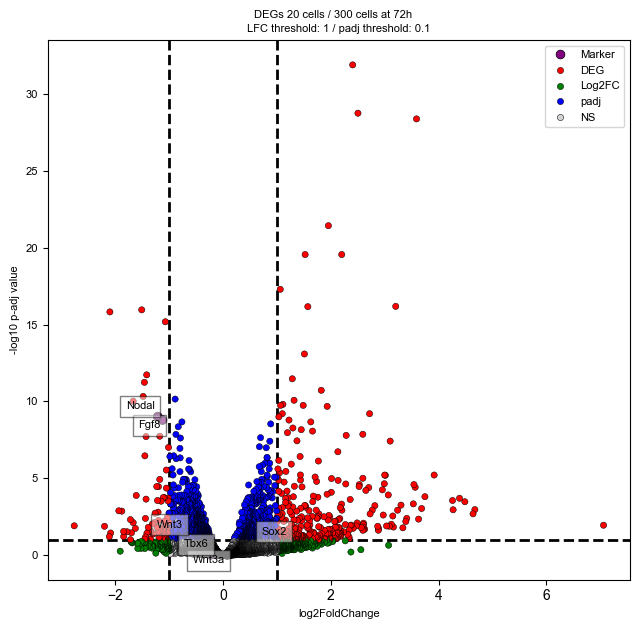

In [86]:
comparisons = [['72h-20c','72h-300c']]
for comparison in comparisons:
    stat_res_df, degs_df = pairwise_comparison(dds, comparison[0], comparison[1], lfc_threshold= 1, padj_threshold= 0.1, save_format='csv')

plot_volcano(stat_res_df,lfc_threshold=1, padj_threshold=0.1, figsize=(6.5,6.5),markers=genes, title='DEGs 20 cells / 300 cells at 72h', filename='20_vs_300cells_72h')

## GO analysis

In [4]:
path2degs=f'{results}/de/degs_120h-20c_vs_120h-300c.csv'

In [5]:
library_ref='GO_Biological_Process_2023'

### Run Enrich function (gseapy)

In [6]:
enr_up, enr_down=go_enrich(f=path2degs, lib=library_ref, go_outdir='results/analysis/go')

### Plot results

In [9]:
plot_enrich(enr_up, padj_threshold=0.1, ntop=30,figsize=(6.5,8), title='up-regulated markers of biological processes',palette=cm.Reds_r,filename=f'{results}/figures/dotplot_go_bp_up_enriched', save_format='tiff')
plot_enrich(enr_down, padj_threshold=0.1, ntop=30,figsize=(6.5,8), title='down-regulated markers of biological processes', palette=cm.Blues_r,filename=f'{results}/figures/dotplot_go_bp_down_enriched', save_format='tiff')
